<a href="https://colab.research.google.com/github/nuriamontala/PYT-SBI/blob/main/PYT_SBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
from torch_geometric.data import Data
import numpy as np
import re
from Bio import PDB

# Hydrophobicity, Polarity, and Charge Information
AA_PROPERTIES = {
    "ALA": [1, 0, 0], "ARG": [0, 1, 1], "ASN": [0, 1, 0], "ASP": [0, 1, -1], "CYS": [1, 0, 0],
    "GLN": [0, 1, 0], "GLU": [0, 1, -1], "GLY": [1, 0, 0], "HIS": [0, 1, 1], "ILE": [1, 0, 0],
    "LEU": [1, 0, 0], "LYS": [0, 1, 1], "MET": [1, 0, 0], "PHE": [1, 0, 0], "PRO": [1, 0, 0],
    "SER": [0, 1, 0], "THR": [0, 1, 0], "TRP": [1, 0, 0], "TYR": [1, 0, 0], "VAL": [1, 0, 0]
}

def extract_binding_sites_from_pdb(pdb_file):
    """
    Extracts binding site information from SITE records in a PDB file.
    Returns a dictionary mapping binding site names to involved residues.
    """
    binding_sites = {}  # Store binding site info
    site_id = 1  # Assign unique numerical IDs to binding sites

    with open(pdb_file, "r") as file:
        for line in file:
            if line.startswith("SITE"):
                parts = line.split()
                site_name = parts[2]  # Extract binding site name (e.g., "AC1", "AC2", etc.)

                # Extract residue details (chain, residue number, residue name)
                for i in range(4, len(parts), 3):
                    if i + 2 < len(parts):  # Ensure valid residue triplet
                        res_name = parts[i]  # Residue name (e.g., TYR)
                        chain_id = parts[i + 1]  # Chain ID (e.g., C)
                        res_id = int(parts[i + 2])  # Residue sequence number (e.g., 89)

                        # Store binding site info
                        if site_name not in binding_sites:
                            binding_sites[site_name] = {"category": site_id, "residues": []}

                        binding_sites[site_name]["residues"].append((chain_id, res_id, res_name))

                site_id += 1  # Assign a new unique binding site ID

    return binding_sites

def compute_edges(residue_positions, cutoff=8.0):
    """
    Computes edges between residues based on Cα atom distances.
    """
    edges = []
    residue_ids = list(residue_positions.keys())
    coords = np.array([residue_positions[rid] for rid in residue_ids])

    for i in range(len(residue_ids)):
        for j in range(i + 1, len(residue_ids)):  # Avoid duplicate pairs
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= cutoff:
                edges.append((residue_ids[i], residue_ids[j]))

    return edges

def create_protein_graph(pdb_file):
    """
    Creates a PyTorch Geometric graph for an entire protein.
    Each node represents a residue with features:
    - Binding site category
    - Hydrophobicity
    - Polarity
    - Charge
    """
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)

    residue_positions = {}
    residue_features = []
    residue_labels = {}  # Stores binding site labels

    # Extract residue coordinates and features
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue, standard=True):  # Skip non-amino acids
                    res_id = (chain.id, residue.id[1])  # Unique residue identifier
                    if "CA" in residue:  # Use Cα atom for positioning
                        residue_positions[res_id] = residue["CA"].coord

                    # Get residue properties (hydrophobicity, polarity, charge)
                    aa_name = residue.resname
                    features = AA_PROPERTIES.get(aa_name, [0, 0, 0])  # Default to neutral
                    residue_features.append(features)
                    residue_labels[res_id] = 0  # Default to non-binding

    # Get binding site information
    binding_sites = extract_binding_sites_from_pdb(pdb_file)

    # ✅ Fix: Ensure residues are correctly labeled as binding sites
    for site_id, site_info in binding_sites.items():
        category_id = site_info["category"]  # Unique ID per binding site
        for chain, res_id, res_name in site_info["residues"]:  # ✅ Fix: Remove res_name from lookup
            if (chain, res_id) in residue_labels:
                residue_labels[(chain, res_id)] = category_id

    # Convert binding site labels to tensor format
    node_labels = torch.tensor([residue_labels[rid] for rid in residue_positions.keys()], dtype=torch.float)

    # Compute edges
    edges = compute_edges(residue_positions)
    residue_index = {rid: i for i, rid in enumerate(residue_positions.keys())}
    edge_index = torch.tensor([[residue_index[r1], residue_index[r2]] for r1, r2 in edges]).t()

    # Convert features to tensor and add binding site information
    node_features = torch.tensor(residue_features, dtype=torch.float)
    node_features = torch.cat((node_features, node_labels.unsqueeze(1)), dim=1)  # Append binding site category

    return Data(x=node_features, edge_index=edge_index, y=node_labels)


In [24]:
def print_node_info(protein_graph, node_idx):
    """
    Prints the feature and connectivity information for a specific node in the protein graph.

    :param protein_graph: PyTorch Geometric Data object
    :param node_idx: Index of the node (residue) to inspect
    """
    # Get the feature vector of the node
    node_features = protein_graph.x[node_idx].tolist()

    # Extract the binding site category (last feature)
    binding_site = node_features[-1]

    # Get connected nodes (edges)
    connected_nodes = protein_graph.edge_index[1][protein_graph.edge_index[0] == node_idx].tolist()

    print(f"Node Index: {node_idx}")
    print(f"Residue Features:")
    print(f"  - Hydrophobicity: {node_features[0]}")
    print(f"  - Polarity: {node_features[1]}")
    print(f"  - Charge: {node_features[2]}")
    print(f"  - Binding Site Category: {binding_site} (0 = Non-binding, >0 = Binding Site ID)")
    print(f"Connected to Nodes: {connected_nodes}")

# Example: Print info of node 5
node_idx = 89
print_node_info(protein_graph, node_idx)


Node Index: 89
Residue Features:
  - Hydrophobicity: 0.0
  - Polarity: 1.0
  - Charge: 0.0
  - Binding Site Category: 0.0 (0 = Non-binding, >0 = Binding Site ID)
Connected to Nodes: [90, 91, 120, 121, 122, 137, 138, 370]


In [20]:
from Bio import PDB
import numpy as np
import pandas as pd

# Load PDB file
pdb_file_path = "1uv6.pdb"  # Make sure the file is in the same directory
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("protein", pdb_file_path)

# Function to extract ligand residues and interacting residues
def analyze_binding_sites(structure, interaction_threshold=5.0):
    ligand_residues = []
    binding_residues = set()

    for model in structure:
        for chain in model:
            for residue in chain:
                # Identify ligand residues (heteroatoms)
                if residue.id[0] != " ":  # Ligands have a non-empty first element in residue.id
                    ligand_residues.append((chain.id, residue.id[1], residue.resname))

                    # Check for interacting residues
                    for neighbor in chain:
                        if PDB.is_aa(neighbor, standard=True) and "CA" in neighbor:
                            if "CA" in residue:
                                dist = np.linalg.norm(residue["CA"].coord - neighbor["CA"].coord)
                                if dist <= interaction_threshold:
                                    binding_residues.add((chain.id, neighbor.id[1], neighbor.resname))

    return ligand_residues, binding_residues

# Run the analysis
ligands, binding_sites = analyze_binding_sites(structure)

# Convert results to DataFrames
ligands_df = pd.DataFrame(ligands, columns=["Chain", "Residue ID", "Ligand Name"])
binding_sites_df = pd.DataFrame(binding_sites, columns=["Chain", "Residue ID", "Residue Name"])

# Print detected ligands
print("Ligands Detected:")
print(ligands_df)

# Print detected binding sites
print("\nBinding Site Residues:")
print(binding_sites_df)


Ligands Detected:
    Chain  Residue ID Ligand Name
0       A        2001         HOH
1       A        2002         HOH
2       A        2003         HOH
3       A        2004         HOH
4       A        2005         HOH
..    ...         ...         ...
96      J        2004         HOH
97      J        2005         HOH
98      J        2006         HOH
99      J        2007         HOH
100     J        2008         HOH

[101 rows x 3 columns]

Binding Site Residues:
Empty DataFrame
Columns: [Chain, Residue ID, Residue Name]
Index: []


In [12]:
pdb_file = "1uv6.pdb"
protein_graph = create_protein_graph(pdb_file)

print(protein_graph)
print("Feature Matrix Shape:", protein_graph.x.shape)
print("Number of Nodes:", protein_graph.x.shape[0])
print("Number of Edges:", protein_graph.edge_index.shape[1])


Data(x=[2050, 4], edge_index=[2, 10335], y=[2050])
Feature Matrix Shape: torch.Size([2050, 4])
Number of Nodes: 2050
Number of Edges: 10335


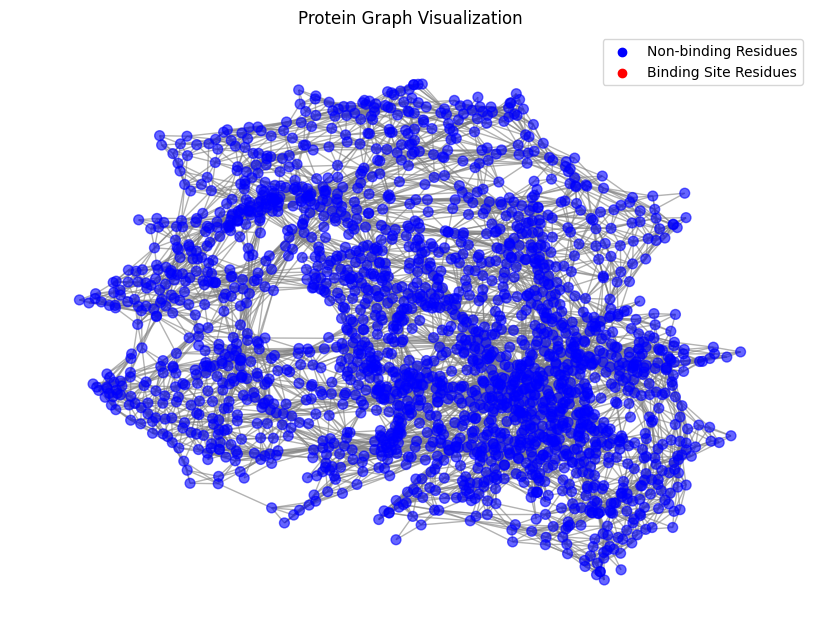

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_protein_graph(protein_graph, title="Protein Graph Visualization"):
    """
    Visualizes the protein graph using NetworkX and Matplotlib.
    Nodes are colored based on binding site labels.
    """
    # Convert PyTorch Geometric graph to NetworkX
    G = to_networkx(protein_graph, to_undirected=True)

    # Get node positions using a force-directed layout
    pos = nx.spring_layout(G, seed=42)

    # Extract binding site information from the node feature matrix
    binding_site_labels = protein_graph.y.numpy()

    # Define node colors:
    # - Non-binding residues (0) are blue
    # - Binding site residues (any other ID) are red
    node_colors = ["red" if label > 0 else "blue" for label in binding_site_labels]

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.6)

    # Legend
    plt.scatter([], [], color="blue", label="Non-binding Residues")
    plt.scatter([], [], color="red", label="Binding Site Residues")
    plt.legend(loc="upper right")

    plt.title(title)
    plt.show()

# Call the function to visualize the graph
visualize_protein_graph(protein_graph)
